In [18]:
import os
import sys

# Thêm thư mục cha vào sys.path
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
sys.path.insert(0, project_dir)

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.random_forest import train_random_forest
from models.logistic_regression import train_logistic_regression
from models.deep_learning import train_deep_learning
from utils.data_processing import clean_data, feature_engineering

# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("CVD Model Training") \
    .getOrCreate()

In [19]:
# Đọc dữ liệu
data_path = os.path.join(project_dir, "data_raw", "CVD_cleaned.csv")
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Làm sạch dữ liệu
cleaned_df = clean_data(df)

# Feature Engineering
featured_df = feature_engineering(cleaned_df)

In [20]:
# Tiền xử lý dữ liệu cho ML
categorical_cols = [
    'General_Health', 'Checkup', 'Sex', 'Age_Category', 'Smoking_History',
    'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis'
]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx").fit(featured_df) for col in categorical_cols]

# Tạo feature vector
feature_cols = [
    'General_Health_idx', 'Checkup_idx', 'Exercise_idx', 'Skin_Cancer_idx', 'Other_Cancer_idx',
    'Depression_idx', 'Diabetes_idx', 'Arthritis_idx', 'Sex_idx', 'Age_Category_idx',
    'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History_idx', 'Alcohol_Consumption',
    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
label_indexer = StringIndexer(inputCol="Heart_Disease", outputCol="label").fit(featured_df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

yes_df = featured_df.filter(featured_df.Heart_Disease == "Yes")
no_df = featured_df.filter(featured_df.Heart_Disease == "No").sample(False, float(yes_df.count())/float(featured_df.filter(featured_df.Heart_Disease == "No").count()), seed=42)
balanced_df = yes_df.union(no_df)

# Tạo pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler])
pipeline_model = pipeline.fit(balanced_df)
df_prepared = pipeline_model.transform(balanced_df)
train, test = df_prepared.randomSplit([0.8, 0.2], seed=42)

Random Forest Results:
AUC: 0.8072
Accuracy: 0.7263
F1-score: 0.7261
Precision: 0.7266
Recall: 0.7263


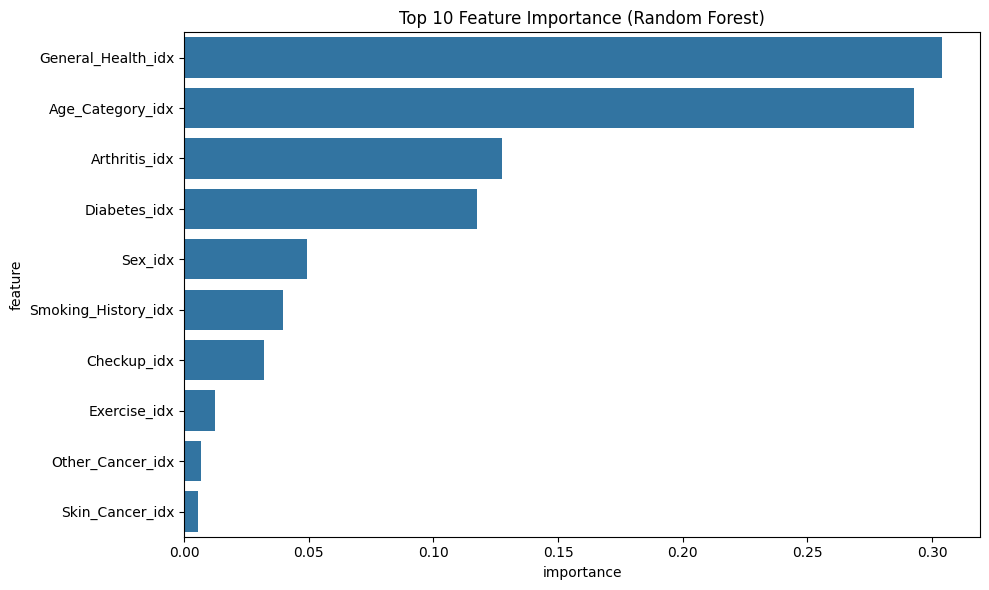

In [21]:
# Train Random Forest model
rf_model, rf_pred, rf_metrics, rf_importances = train_random_forest(train, test)

print("Random Forest Results:")
print(f"AUC: {rf_metrics['auc']:.4f}")
print(f"Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"F1-score: {rf_metrics['f1']:.4f}")
print(f"Precision: {rf_metrics['precision']:.4f}")
print(f"Recall: {rf_metrics['recall']:.4f}")

# Visualize feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [22]:
# Train Logistic Regression
lr_model, lr_pred, lr_metrics = train_logistic_regression(train, test)

print("\nLogistic Regression Results:")
print(f"AUC: {lr_metrics['auc']:.4f}")
print(f"Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"F1-score: {lr_metrics['f1']:.4f}")
print(f"Precision: {lr_metrics['precision']:.4f}")
print(f"Recall: {lr_metrics['recall']:.4f}")


Logistic Regression Results:
AUC: 0.7816
Accuracy: 0.7070
F1-score: 0.7070
Precision: 0.7070
Recall: 0.7070


Epoch 1/10


c:\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6031 - loss: 1.7800 - val_accuracy: 0.6659 - val_loss: 0.5962
Epoch 2/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6684 - loss: 0.6262 - val_accuracy: 0.7120 - val_loss: 0.5766
Epoch 3/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6866 - loss: 0.5975 - val_accuracy: 0.7105 - val_loss: 0.5659
Epoch 4/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6920 - loss: 0.5880 - val_accuracy: 0.7173 - val_loss: 0.5732
Epoch 5/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6956 - loss: 0.5813 - val_accuracy: 0.7160 - val_loss: 0.5676
Epoch 6/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7005 - loss: 0.5723 - val_accuracy: 0.7082 - val_loss: 0.5659
Epoch 7/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6990 - loss: 0.5783 - val_accuracy: 0.7000 - val_loss: 0.5637
Epoch 8/10
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7057 - loss: 0.5671 - val_accurac

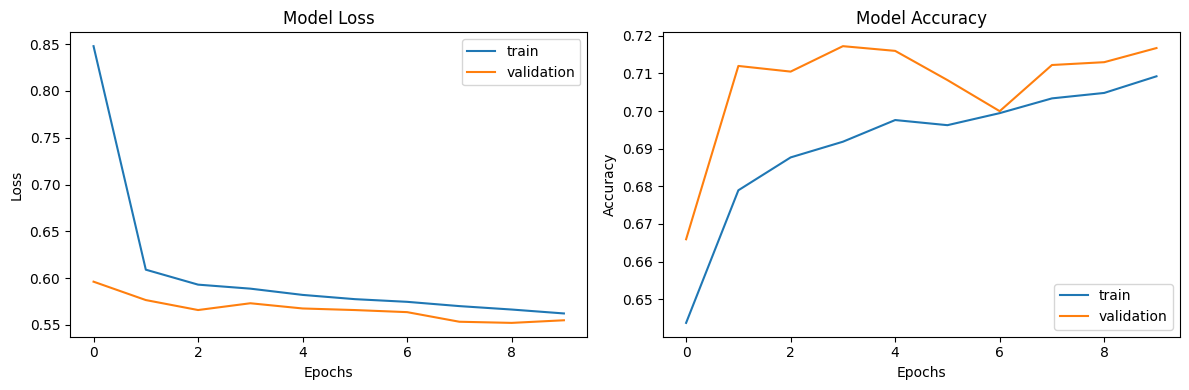

In [23]:
# Prepare data for Deep Learning
pandas_df = df_prepared.select(feature_cols + ["label"]).toPandas()
X = pandas_df[feature_cols].values
y = pandas_df["label"].values

# Train Deep Learning model
dl_model, dl_history, dl_metrics, dl_test_data = train_deep_learning(X, y)

print("\nDeep Learning Results:")
print(f"Loss: {dl_metrics['loss']:.4f}")
print(f"Accuracy: {dl_metrics['accuracy']:.4f}")
print(f"AUC: {dl_metrics['auc']:.4f}")
print(f"F1-score: {dl_metrics['f1']:.4f}")
print(f"Precision: {dl_metrics['precision']:.4f}")
print(f"Recall: {dl_metrics['recall']:.4f}")
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dl_history.history['loss'], label='train')
plt.plot(dl_history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dl_history.history['accuracy'], label='train')
plt.plot(dl_history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

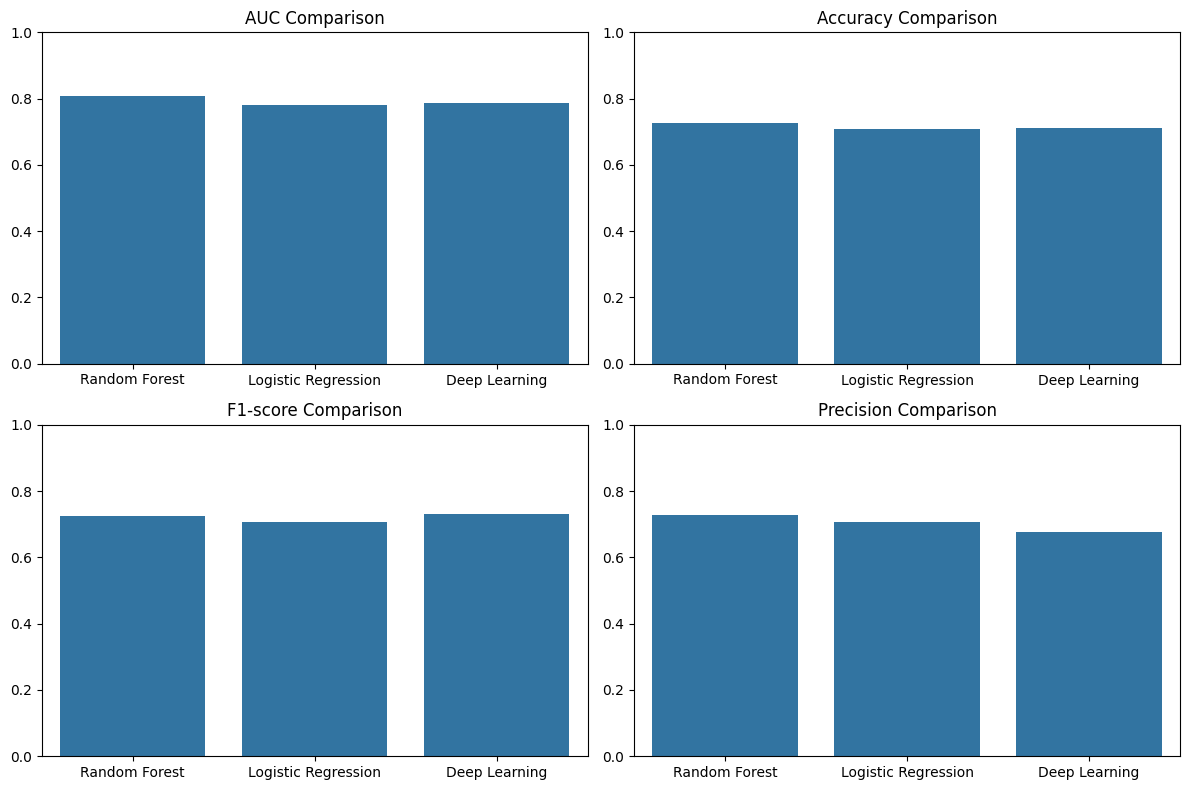

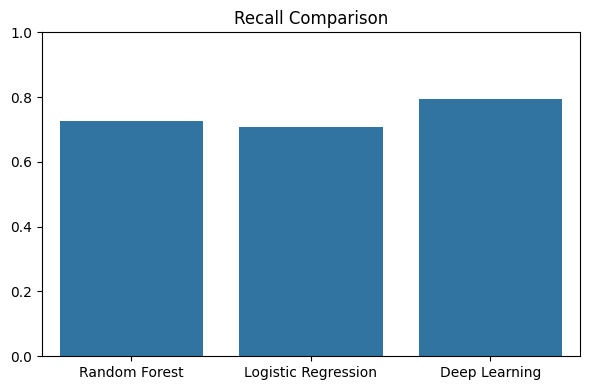

Prediction results saved to: c:\Users\racco\Documents\IE212\DOAN\CVD_Prediction_System\data_result\predictions.csv


In [24]:
# Compare all models
models = ['Random Forest', 'Logistic Regression', 'Deep Learning']
auc_scores = [rf_metrics['auc'], lr_metrics['auc'], dl_metrics['auc']]
accuracies = [rf_metrics['accuracy'], lr_metrics['accuracy'], dl_metrics['accuracy']]
f1_scores = [rf_metrics['f1'], lr_metrics['f1'], dl_metrics['f1']]
precisions = [rf_metrics['precision'], lr_metrics['precision'], dl_metrics['precision']]
recalls = [rf_metrics['recall'], lr_metrics['recall'], dl_metrics['recall']]

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
sns.barplot(x=models, y=auc_scores)
plt.title('AUC Comparison')
plt.ylim(0, 1)
plt.subplot(2,2,2)
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.subplot(2,2,3)
sns.barplot(x=models, y=f1_scores)
plt.title('F1-score Comparison')
plt.ylim(0, 1)
plt.subplot(2,2,4)
sns.barplot(x=models, y=precisions)
plt.title('Precision Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=recalls)
plt.title('Recall Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
# Đảm bảo thư mục tồn tại
os.makedirs(os.path.join(project_dir, "data_result"), exist_ok=True)

# Tạo cột mới Predicted_Heart_Disease là Yes/No
predictions_df = rf_pred.withColumn(
    "Predicted_Heart_Disease",
    when(rf_pred["prediction"] == 1.0, "Yes").otherwise("No")
).select(
    "General_Health", "Checkup", "Sex", "Age_Category", "BMI",
    "Smoking_History", "Alcohol_Consumption", "Heart_Disease",
    "Fruit_Consumption", "Green_Vegetables_Consumption",
    "Exercise", "Predicted_Heart_Disease"
)

# Chuyển sang pandas và lưu
predictions_path = os.path.join(project_dir, "data_result", "predictions.csv")
predictions_df.toPandas().to_csv(predictions_path, index=False)
print(f"Prediction results saved to: {predictions_path}")


=== ĐÁNH GIÁ DỰ ĐOÁN VỚI NHÃN THẬT ===
Accuracy:  0.7263
F1-score:  0.7175
Precision: 0.7350
Recall:    0.7008
Confusion matrix:


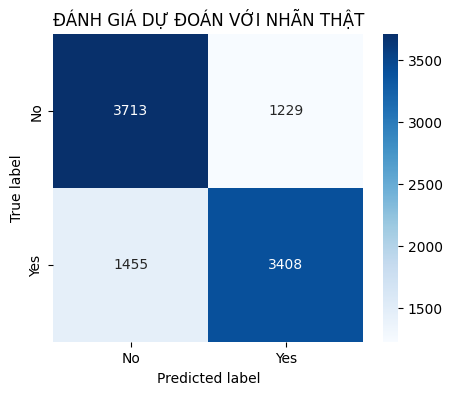

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Đọc lại file kết quả dự đoán
predictions_path = os.path.join(project_dir, "data_result", "predictions.csv")
df_pred = pd.read_csv(predictions_path)

# Chuyển Yes/No thành 1/0
y_true = df_pred["Heart_Disease"].map({"No": 0, "Yes": 1}).values
y_pred = df_pred["Predicted_Heart_Disease"].map({"No": 0, "Yes": 1}).values

# Tính các chỉ số
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("\n=== ĐÁNH GIÁ DỰ ĐOÁN VỚI NHÃN THẬT ===")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print("Confusion matrix:")
labels = ["No", "Yes"]  # hoặc ["Không", "Có"] nếu bạn muốn tiếng Việt
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("ĐÁNH GIÁ DỰ ĐOÁN VỚI NHÃN THẬT")
plt.show()